In [1]:
import pandas as pd
import numpy as np

import jax
import jax.numpy as jnp
import pylab as plt

In [2]:
df = pd.read_csv("D:\Academic\Y4S2\DSA4212\Assignment\songsDataset.csv", header=0, names=['userID','songID','rating'])

In [3]:
df.head(2)

,userID,songID,rating
0,0,7171,5
1,0,8637,4


In [4]:
df.shape

(2000000, 3)

In [5]:
df['userID'].nunique()

200000

In [6]:
df['userID'].value_counts().describe()

count    200000.0
mean         10.0
std           0.0
min          10.0
25%          10.0
50%          10.0
75%          10.0
max          10.0
Name: count, dtype: float64

In [7]:
df['songID'].nunique()

127771

In [8]:
df['songID'].value_counts().describe()

count    127771.000000
mean         15.653004
std          54.576728
min           1.000000
25%           2.000000
50%           5.000000
75%          10.000000
max        1904.000000
Name: count, dtype: float64

In [9]:
df.isnull().sum()

userID    0
songID    0
rating    0
dtype: int64

In [10]:
df['rating'].describe()

count    2.000000e+06
mean     3.459467e+00
std      1.553719e+00
min      1.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

<Axes: >

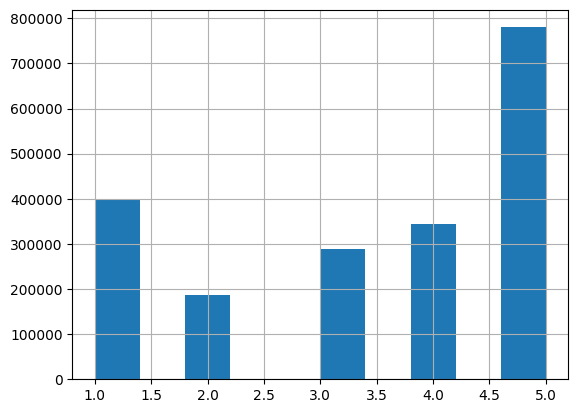

In [11]:
df['rating'].hist()

In [12]:
df_tmp = df[['userID','songID']].copy()
sum(df_tmp.duplicated()) # no duplicates

0

In [13]:
np.mean((df['rating']-np.mean(df['rating']))**2)

2.414040075911

In [14]:
np.mean(df.groupby('userID')['rating'].transform(lambda x: (x - x.mean())**2))

1.4875168999999995

In [15]:
np.mean(df.groupby('songID')['rating'].transform(lambda x: (x - x.mean())**2))

2.0228410439086004

### Mean-user

In [17]:
N_songs = df['songID'].nunique()
N_users = df['userID'].nunique()
N_ratings = df.shape[0]

In [45]:
M = np.mean(df['rating'])
alpha_list = [1e-4, 1e-2, 1, 10, 100]
errors = []
for alpha in alpha_list:
    errors.append(np.mean(df.groupby('userID')['rating'].transform(lambda x: (x-1/(alpha+len(x))*(alpha*M+sum(x)))**2)))

Text(0.5, 0, 'Alpha')

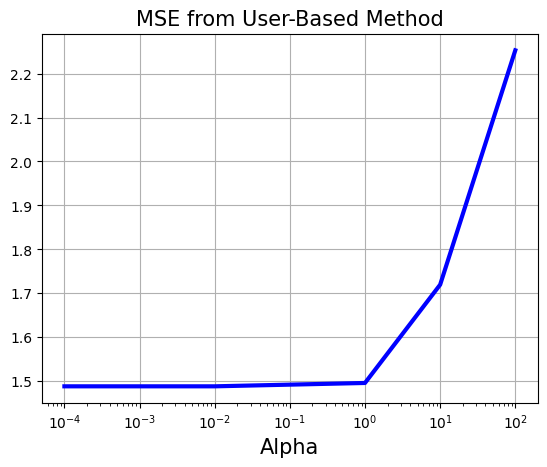

In [46]:
plt.plot(alpha_list, errors,'-',lw=3,color='blue')
plt.grid()
plt.xscale('log')
plt.title('MSE from User-Based Method',fontsize=15)
plt.xlabel('Alpha',fontsize=15)

In [47]:
errors

[1.4875169000926514,
 1.4875178246729062,
 1.4951741163298429,
 1.7191476939777504,
 2.2532385329842977]

### Mean-item

In [48]:
errors = []
for alpha in alpha_list:
    errors.append(np.mean(df.groupby('songID')['rating'].transform(lambda x: (x-1/(alpha+len(x))*(alpha*M+sum(x)))**2)))

Text(0.5, 0, 'Alpha')

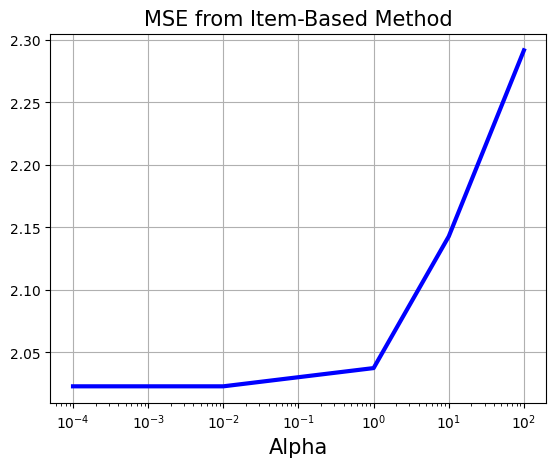

In [49]:
plt.plot(alpha_list, errors,'-',lw=3,color='blue')
plt.grid()
plt.xscale('log')
plt.title('MSE from Item-Based Method',fontsize=15)
plt.xlabel('Alpha',fontsize=15)

In [50]:
errors

[2.0228410443080262,
 2.022844979232786,
 2.0374416379712508,
 2.14285451221291,
 2.2917432501748096]

### Low Rank Factorization M~UV

In [51]:
Obs_users = df['userID'].copy().to_numpy()
Obs_songs = df['songID'].copy().to_numpy()
Ratings = df['rating'].copy().to_numpy()

In [52]:
Obs_users.shape,Obs_songs.shape,Ratings.shape

((2000000,), (2000000,), (2000000,))

In [53]:
d_factors = 5
U_init = np.random.normal(3,1,size=(N_users,d_factors))/np.sqrt(d_factors) # midpoint of the rating scale
S_init = np.random.normal(3,1,size=(N_songs,d_factors))/np.sqrt(d_factors)

In [56]:
@jax.jit
def loss(U_single,S_single,rating_single):
    pred = jnp.dot(U_single,S_single)
    error = (rating_single-pred)**2
    return error
loss_grad = jax.jit(jax.grad(loss,argnums=(0,1)))

def mse(U_batch,S_batch,ratings_batch):
    predictions = np.sum(U_batch*S_batch,axis=1)
    errors = (ratings_batch-predictions)**2
    return np.mean(errors)

In [57]:
df['userID'].max()

199999

In [58]:
df['userID'].nunique()

200000

In [59]:
df['songID'].max()

136735

In [60]:
df['songID'].nunique() # song ids are not continuous

127771

In [61]:
song_ids = list(df['songID'].unique())

In [62]:
niter = 10
learning_rate = 0.01
U = U_init.copy()
S = S_init.copy()
MSE_lr = []

for it in range(niter):
    for index in range(20000):
        index = np.random.randint(N_ratings)
        user_id = Obs_users[index]
        song_id = Obs_songs[index]
        song_index = song_ids.index(song_id)
        rating = Ratings[index]
        U_grad, S_grad = loss_grad(U[user_id],S[song_index],rating)
        U[user_id] -= learning_rate*U_grad
        S[song_index] -= learning_rate*S_grad

    U_batch = U[:10000]
    song_indices = [song_ids.index(e) for e in Obs_songs[:10000]]
    S_batch = S[song_indices]
    ratings_batch = Ratings[:10000]
    mse_current = mse(U_batch,S_batch,ratings_batch)
    MSE_lr.append(mse_current)
    print(f"iter {it+1}, mse={mse_current:.5f}")
        
    # if it%10==0:
    #     U_batch = U[Obs_users[:1000]]
    #     song_indices = [song_ids.index(e) for e in Obs_songs[:1000]]
    #     S_batch = S[song_indices]
    #     ratings_batch = Ratings[:1000]
    #     mse_current = mse(U_batch,S_batch,ratings_batch)
    #     MSE.append(mse_current)
    #     print(f"iter {it}, mse={mse_current:.5f}")

iter 1, mse=25.29917
iter 2, mse=21.28603
iter 3, mse=18.76625
iter 4, mse=17.06030
iter 5, mse=15.77096
iter 6, mse=14.69198
iter 7, mse=13.84793
iter 8, mse=13.18407
iter 9, mse=12.56088
iter 10, mse=12.05170


In [63]:
niter = 100
learning_rate = 0.01
U = U_init.copy()
S = S_init.copy()
MSE_lr = []

for it in range(niter):
    for index in range(20000):
        index = np.random.randint(N_ratings)
        user_id = Obs_users[index]
        song_id = Obs_songs[index]
        song_index = song_ids.index(song_id)
        rating = Ratings[index]
        U_grad, S_grad = loss_grad(U[user_id],S[song_index],rating)
        U[user_id] -= learning_rate*U_grad
        S[song_index] -= learning_rate*S_grad
        
    if ((it+1)%10==0) | (it==0):
        U_batch = U[:10000]
        song_indices = [song_ids.index(e) for e in Obs_songs[:10000]]
        S_batch = S[song_indices]
        ratings_batch = Ratings[:10000]
        mse_current = mse(U_batch,S_batch,ratings_batch)
        MSE_lr.append(mse_current)
        print(f"iter {it+1}, mse={mse_current:.5f}")

iter 1, mse=25.22949
iter 10, mse=12.12509
iter 20, mse=8.82363
iter 30, mse=7.16789
iter 40, mse=6.23402
iter 50, mse=5.64302
iter 60, mse=5.22306
iter 70, mse=4.87198
iter 80, mse=4.64410
iter 90, mse=4.43332
iter 100, mse=4.29249


Text(0.5, 0, 'iteration')

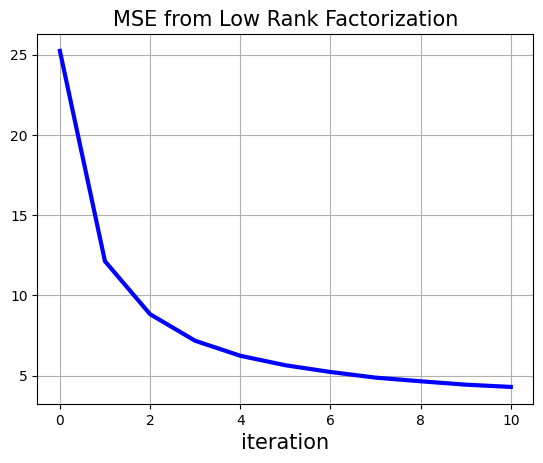

In [64]:
plt.plot(MSE_lr,'-',lw=3,color='blue')
plt.grid()
plt.title('MSE from Low Rank Factorization',fontsize=15)
plt.xlabel('iteration',fontsize=15)

### Nonnegative Factorization

In [65]:
U_init = np.random.normal(3,1,size=(N_users,d_factors))/np.sqrt(d_factors)
S_init = np.random.normal(3,1,size=(N_songs,d_factors))/np.sqrt(d_factors)

U_init = np.maximum(U_init,0)
S_init = np.maximum(S_init,0)

In [66]:
niter = 200
learning_rate = 0.01
U = U_init.copy()
S = S_init.copy()
MSE_nmf = []

for it in range(niter):
    for index in range(20000):
        index = np.random.randint(N_ratings)
        user_id = Obs_users[index]
        song_id = Obs_songs[index]
        song_index = song_ids.index(song_id)
        rating = Ratings[index]
        U_grad, S_grad = loss_grad(U[user_id],S[song_index],rating)
        U[user_id] -= learning_rate*U_grad
        S[song_index] -= learning_rate*S_grad
    U = np.maximum(U, 0)
    S = np.maximum(S, 0)
        
    if ((it+1)%10==0) | (it==0):
        U_batch = U[:10000]
        song_indices = [song_ids.index(e) for e in Obs_songs[:10000]]
        S_batch = S[song_indices]
        ratings_batch = Ratings[:10000]
        mse_current = mse(U_batch,S_batch,ratings_batch)
        MSE_nmf.append(mse_current)
        print(f"iter {it+1}, mse={mse_current:.5f}")

iter 1, mse=25.09824
iter 10, mse=11.81633
iter 20, mse=8.69286
iter 30, mse=7.13857
iter 40, mse=6.22054
iter 50, mse=5.65319
iter 60, mse=5.20295
iter 70, mse=4.89944
iter 80, mse=4.62954
iter 90, mse=4.43153
iter 100, mse=4.28349
iter 110, mse=4.13373
iter 120, mse=4.03910
iter 130, mse=3.97282
iter 140, mse=3.86921
iter 150, mse=3.80834
iter 160, mse=3.74726
iter 170, mse=3.70735
iter 180, mse=3.67578
iter 190, mse=3.65683
iter 200, mse=3.60342


Text(0.5, 0, 'iteration')

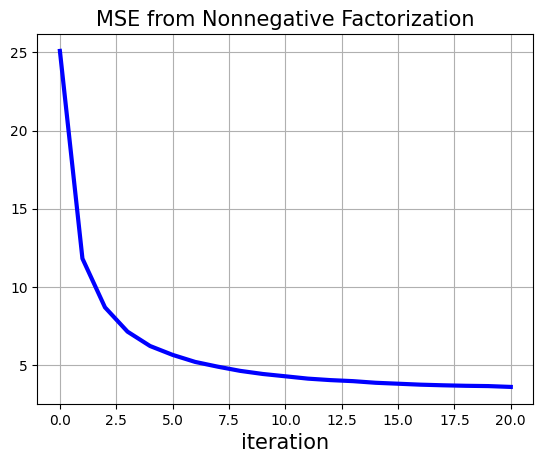

In [68]:
plt.plot(MSE_nmf,'-',lw=3,color='blue')
plt.grid()
plt.title('MSE from Nonnegative Factorization',fontsize=15)
plt.xlabel('iteration',fontsize=15)

##### With Regularization

In [72]:
@jax.jit
def loss_regularize(U_single,S_single,rating_single,lam):
    error = (rating_single-jnp.dot(U_single,S_single))**2+(lam/N_users)*jnp.linalg.norm(U_single)**2+(lam/N_songs)*jnp.linalg.norm(S_single)
    return error
loss_regularize_grad = jax.jit(jax.grad(loss_regularize,argnums=(0,1)))

In [74]:
niter = 10
learning_rate = 0.01
U = U_init.copy()
S = S_init.copy()
MSE_nmf_r = []
lam = 0.01

for it in range(niter):
    for index in range(20000):
        index = np.random.randint(N_ratings)
        user_id = Obs_users[index]
        song_id = Obs_songs[index]
        song_index = song_ids.index(song_id)
        rating = Ratings[index]
        U_grad, S_grad = loss_regularize_grad(U[user_id],S[song_index],rating,lam)
        U[user_id] -= learning_rate*U_grad
        S[song_index] -= learning_rate*S_grad
    U = np.maximum(U, 0)
    S = np.maximum(S, 0)
        
    if ((it+1)%10==0) | (it==0):
        U_batch = U[:10000]
        song_indices = [song_ids.index(e) for e in Obs_songs[:10000]]
        S_batch = S[song_indices]
        ratings_batch = Ratings[:10000]
        mse_current = mse(U_batch,S_batch,ratings_batch)
        MSE_nmf_r.append(mse_current)
        print(f"iter {it+1}, mse={mse_current:.5f}")

iter 1, mse=25.03070
iter 10, mse=11.73790
